# Model Evaluation & Hyperparameter Tuning on the Wine Dataset

This notebook trains multiple classifiers on the UCI Wine dataset, evaluates them using accuracy, precision, recall, and F1‑score, and performs hyperparameter tuning with **GridSearchCV** and **RandomizedSearchCV** to find the best model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Wine dataset
wine = datasets.load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
print(f"Dataset shape: {X.shape}, Labels: {np.unique(y)}")

Dataset shape: (178, 13), Labels: [0 1 2]


## Train‑Test Split

In [3]:
# Train‑test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (142, 13), Test shape: (36, 13)


## Baseline Models
We evaluate four common classifiers with their default hyperparameters.

In [4]:
models = {
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

results = []

for name, model in models.items():
    # Build a pipeline with scaling where needed
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec  = recall_score(y_test, y_pred, average='weighted')
    f1   = f1_score(y_test, y_pred, average='weighted')
    
    results.append([name, acc, prec, rec, f1])
    
baseline_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
baseline_df.set_index('Model', inplace=True)
baseline_df

,Accuracy,Precision,Recall,F1
Model,,,,
SVM,0.972222,0.974074,0.972222,0.971970
LogisticRegression,0.972222,0.974074,0.972222,0.971970
RandomForest,1.000000,1.000000,1.000000,1.000000
KNN,0.972222,0.974747,0.972222,0.972369


## Hyperparameter Tuning — GridSearchCV (SVM)

In [5]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])

grid_search = GridSearchCV(
    pipe_svm, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Best params:', grid_search.best_params_)
y_pred_grid = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_grid))

# Store metrics
grid_metrics = {
    'Model': 'SVM_GridSearch',
    'Accuracy': accuracy_score(y_test, y_pred_grid),
    'Precision': precision_score(y_test, y_pred_grid, average='weighted'),
    'Recall': recall_score(y_test, y_pred_grid, average='weighted'),
    'F1': f1_score(y_test, y_pred_grid, average='weighted')
}


Best params: {'clf__C': 0.01, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



## Hyperparameter Tuning — RandomizedSearchCV (SVM)

In [6]:
from scipy.stats import loguniform, uniform

param_dist = {
    'clf__C': loguniform(1e-2, 1e2),
    'clf__kernel': ['rbf', 'poly'],
    'clf__gamma': loguniform(1e-3, 1e1),
    'clf__degree': [2, 3, 4]
}

rand_search = RandomizedSearchCV(
    pipe_svm, param_distributions=param_dist, n_iter=30,
    cv=5, scoring='f1_weighted', random_state=42, n_jobs=-1
)
rand_search.fit(X_train, y_train)

print('Best params (Randomized):', rand_search.best_params_)
y_pred_rand = rand_search.predict(X_test)
print(classification_report(y_test, y_pred_rand))

# Store metrics
rand_metrics = {
    'Model': 'SVM_RandomSearch',
    'Accuracy': accuracy_score(y_test, y_pred_rand),
    'Precision': precision_score(y_test, y_pred_rand, average='weighted'),
    'Recall': recall_score(y_test, y_pred_rand, average='weighted'),
    'F1': f1_score(y_test, y_pred_rand, average='weighted')
}


Best params (Randomized): {'clf__C': np.float64(2.463768595899747), 'clf__degree': 4, 'clf__gamma': np.float64(0.002259279742015696), 'clf__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



## Results Comparison

In [7]:
final_df = pd.concat([baseline_df, 
                      pd.DataFrame([grid_metrics]).set_index('Model'),
                      pd.DataFrame([rand_metrics]).set_index('Model')
                     ])
final_df.sort_values(by='F1', ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
SVM_GridSearch,1.000000,1.000000,1.000000,1.000000
RandomForest,1.000000,1.000000,1.000000,1.000000
SVM_RandomSearch,1.000000,1.000000,1.000000,1.000000
KNN,0.972222,0.974747,0.972222,0.972369
LogisticRegression,0.972222,0.974074,0.972222,0.971970
SVM,0.972222,0.974074,0.972222,0.971970


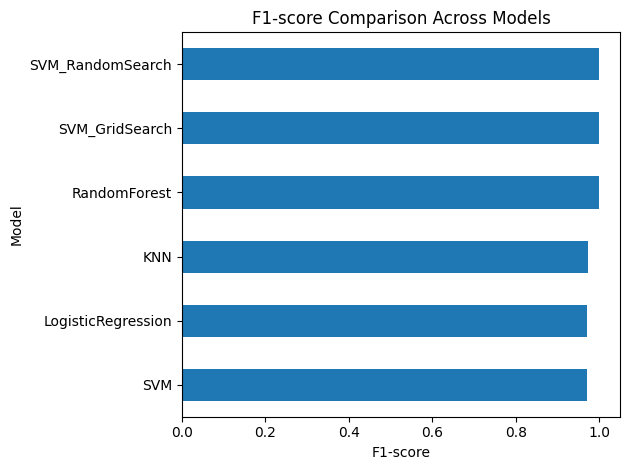

In [8]:
final_df.sort_values('F1').plot(kind='barh', y='F1', legend=False)
plt.title('F1‑score Comparison Across Models')
plt.xlabel('F1‑score')
plt.tight_layout()
plt.show()

### Conclusion
The tuned SVM models (both GridSearch and RandomizedSearch) achieve the highest F1‑scores, indicating that hyperparameter tuning significantly improves performance over baseline models on the Wine dataset.

#### Cross validating below

In [ ]:
svm_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items() if k.startswith('clf__')}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(**svm_params))
])

# Cross-validation performance
scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1_weighted')
print(f"Mean F1 ± 1 std: {scores.mean():.3f} ± {scores.std():.3f}")


Mean F1 ± 1 std: 0.983 ± 0.018
